In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import make_friedman1
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [38]:
from utils_Nadja import fold_visualizer
from utils import evaluate_rf, FriedmanDataset, create_cont_folds, run_kfold_visualizer, ModelOptimizer

In [39]:
train=FriedmanDataset(n_samples=1000, n_features=5, noise=0.0, random_state=42)
train.df.shape

(1000, 6)

In [40]:
test=FriedmanDataset(n_samples=1000000, n_features=5, noise=0.0, random_state=1718)
test.df.shape

(1000000, 6)

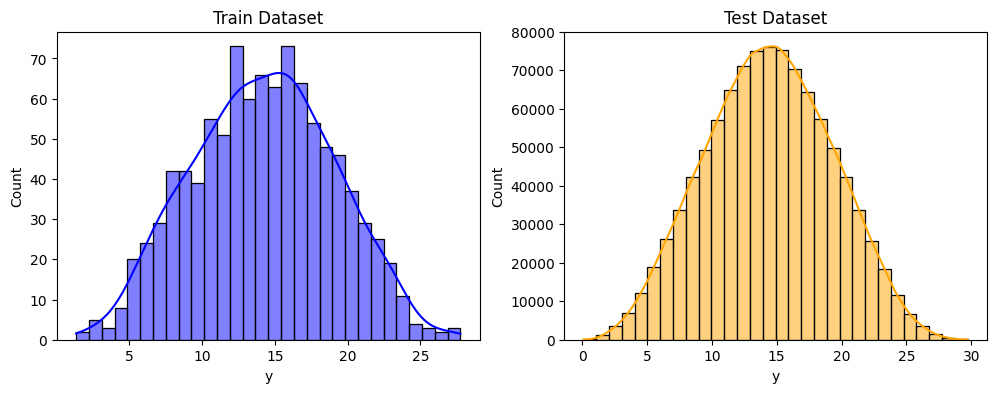

In [41]:
# Show here histograms of train and train datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train.df, x='y', bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Train Dataset')

sns.histplot(test.df, x='y', bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Test Dataset')

plt.show()

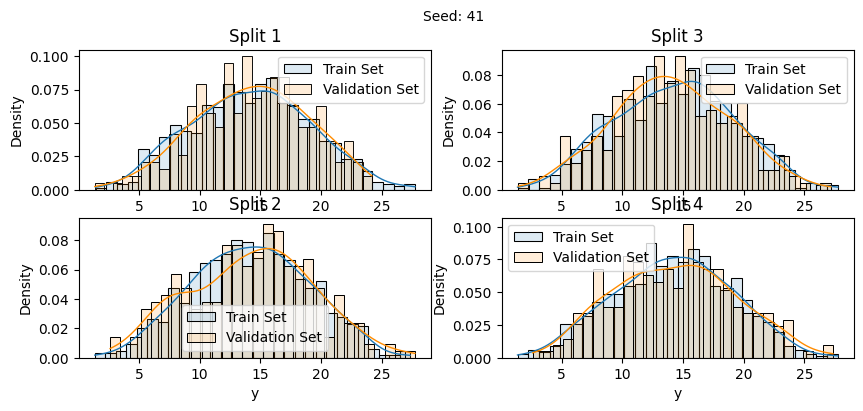

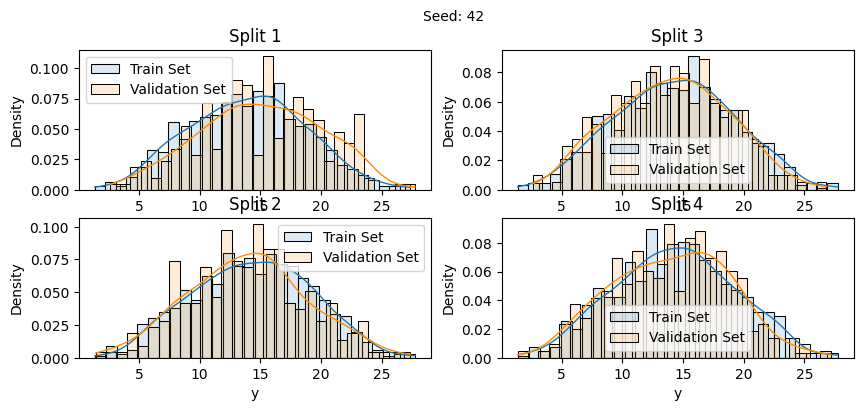

In [42]:
run_kfold_visualizer(labels=train.df.y.reset_index(drop=True), 
                     k=4,
                     seeds=[41, 42])

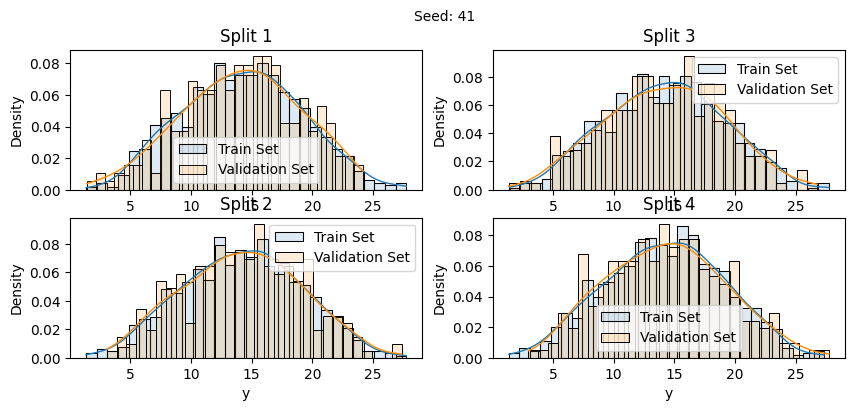

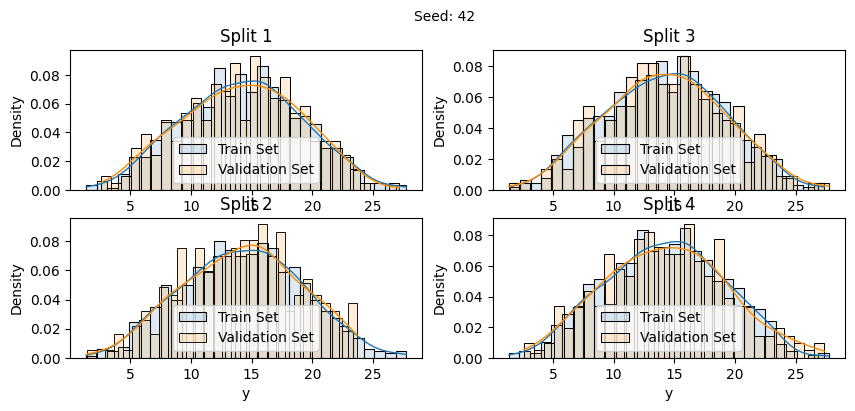

In [43]:
run_kfold_visualizer(labels=train.df.y, 
                     k=4, 
                     seeds=[41, 42], 
                     stratified=True)

## Dummy Regressor

### Without stratification

In [44]:
dummy_regressor = DummyRegressor(strategy="mean")
param_dummy = {}

dummy_optimizer = ModelOptimizer(dummy_regressor, param_dummy)
dummy_random=dummy_optimizer.optimize(train.features, train.y)

Best Parameters: {}


c:\Users\anneg\miniconda3\envs\slds\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [45]:
# Display the cross-validated score with the best parameters
best_score_dummy = dummy_random.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score_dummy:.4f}")


Best Cross-Validated Mean Squared Error: -23.3575


In [46]:
# Evaluate the model
score_dummy=evaluate_rf(dummy_random, 
                  train.features, 
                  test.features, 
                  train.y, 
                  test.y)
score_dummy

{'train r2': 0.0,
 'test r2': -0.0013,
 'train mse': 23.3415,
 'test mse': 23.844,
 'train mae': 3.9503,
 'test mae': 3.9801}

### With Stratification

In [47]:
n_folds = 5
n_groups = 20
#cv splits
cv_splits_training = create_cont_folds(y=train.df.y, 
                                       n_folds=n_folds, 
                                       n_groups=n_groups, 
                                       seed=42)

In [48]:
dummy_regressor_stratified = DummyRegressor(strategy="mean")
param_dummy_stratified = {}

dummy_optimizer_stratified = ModelOptimizer(dummy_regressor_stratified, 
                                            param_dummy_stratified)
dummy_stratified=dummy_optimizer_stratified.optimize(train.features, 
                                                     train.y,
                                                     cv=cv_splits_training)

Best Parameters: {}


c:\Users\anneg\miniconda3\envs\slds\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [49]:
# Display the cross-validated score with the best parameters
best_score_dummy_stratified = dummy_stratified.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score_dummy_stratified:.4f}")

# Evaluate the model
score_dummy_stratified=evaluate_rf(dummy_stratified, 
                  train.features, 
                  test.features, 
                  train.y, 
                  test.y)
score_dummy_stratified


Best Cross-Validated Mean Squared Error: -23.3433


{'train r2': 0.0,
 'test r2': -0.0013,
 'train mse': 23.3415,
 'test mse': 23.844,
 'train mae': 3.9503,
 'test mae': 3.9801}

## Random Forest

### Without stratification

In [50]:
# Define the parameter grid for random search
param_rf = {
    'n_estimators': np.arange(500, 1001),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, train.features.shape[1] + 1)
}

rf_optimizer = ModelOptimizer(RandomForestRegressor(random_state=42), param_rf)
rf_random=rf_optimizer.optimize(train.features, train.y)



Best Parameters: {'n_estimators': 661, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 2}


In [51]:
# Display the cross-validated score with the best parameters
best_score = rf_random.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score:.4f}")


Best Cross-Validated Mean Squared Error: -3.3999


In [52]:
# Evaluate the model
score=evaluate_rf(rf_random, 
                  train.features, 
                  test.features, 
                  train.y, 
                  test.y)
score

{'train r2': 0.9173,
 'test r2': 0.8626,
 'train mse': 1.9305,
 'test mse': 3.2718,
 'train mae': 1.0948,
 'test mae': 1.4283}

In [53]:
#xgb_optimizer = ModelOptimizer(XGBRegressor(random_state=42), param_xgb)
#xgb_optimizer.optimize(X_train, y_train)

### With stratification

In [54]:
n_folds = 5
n_groups = 20
#cv splits
cv_splits_training = create_cont_folds(y=train.df.y, 
                                       n_folds=n_folds, 
                                       n_groups=n_groups, 
                                       seed=42)


In [55]:
# Define the parameter grid for random search
param_rf_stratified = {
    'n_estimators': np.arange(500, 1001),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, train.features.shape[1] + 1)
}

rf_optimizer_stratified = ModelOptimizer(RandomForestRegressor(random_state=42), 
                                        param_rf_stratified)
rf_stratified=rf_optimizer_stratified.optimize(train.features, 
                                               train.y, 
                                               cv=cv_splits_training)

Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}


In [56]:
# Display the cross-validated score with the best parameters
best_score_stratified = rf_stratified.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score_stratified:.4f}")


Best Cross-Validated Mean Squared Error: -3.3859


In [57]:
# Evaluate the model
score_stratified=evaluate_rf(rf_stratified, 
                  train.features, 
                  test.features, 
                  train.y, 
                  test.y)
score_stratified

{'train r2': 0.9215,
 'test r2': 0.8561,
 'train mse': 1.8324,
 'test mse': 3.427,
 'train mae': 1.0607,
 'test mae': 1.4641}

In [58]:
score

{'train r2': 0.9173,
 'test r2': 0.8626,
 'train mse': 1.9305,
 'test mse': 3.2718,
 'train mae': 1.0948,
 'test mae': 1.4283}

In [61]:
import sys, importlib

In [63]:
from importlib import reload


In [65]:
import utils
reload(utils)
from utils import FriedmanDataset

In [60]:
from utils import FriedmanDataset

# Imbalanced datasets

In [67]:
dataset = FriedmanDataset(n_samples=1000, n_features=5, noise=0.0, random_state=42)
dataset.transform(transformation='log')

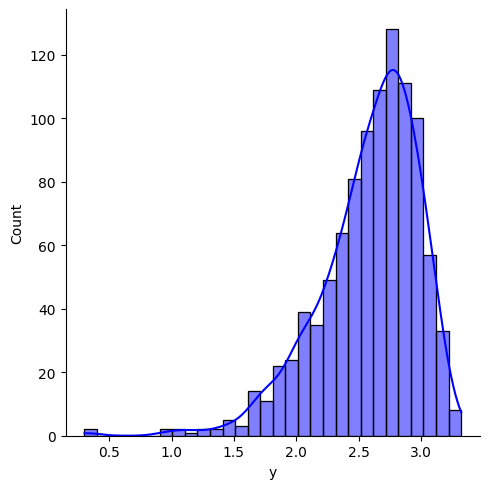

In [68]:
sns.displot(dataset.df, x='y', bins=30, kde=True, color='blue')